# COGS 189: Final Project
### Members: Ehson Pirouzian, ... write your own

This is our Winter 2022 Final Project for COGS 189
The purpose is a machine learning project that relates to motor sensory data from BCI competition IV dataset 2a

### Hypothesis

ADD which one we think.

Is it easiest to classify data left hand sensory data against right hand, foot, or tounge sensory data?

### Code

We will use matlab and python for how we test our hypothesis


#### Importing the data

In [69]:
import os
import numpy as np
import pandas as pd
from pprint import pprint
import scipy.io as sio
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [70]:
# Get the raw value
raw = mne.io.read_raw_gdf('./BCICIV_2a_gdf/A01T.gdf', preload=True)

eegbci.standardize(raw)  # set channel names

# infoChs = channelNames(info.raw['chs'])
# print(raw.info['chs'])

Extracting EDF parameters from /Users/ehson/Documents/Classes/COGS189/Cogs-189-Project/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/Users/ehson/miniconda3/envs/cogs/lib/python3.9/site-packages/mne/io/edf/edf.py:1131: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/Users/ehson/miniconda3/envs/cogs/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Effective window size : 8.192 (s)


/var/folders/vm/4clncyz129b_xbn8m9snhw780000gn/T/ipykernel_98104/1925098452.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)


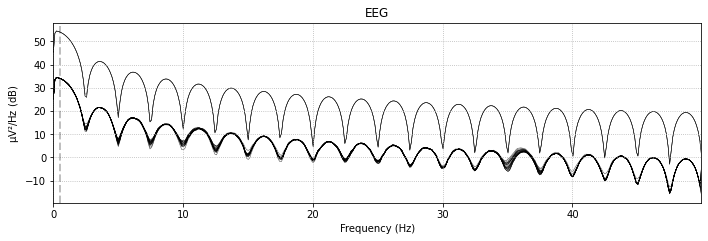

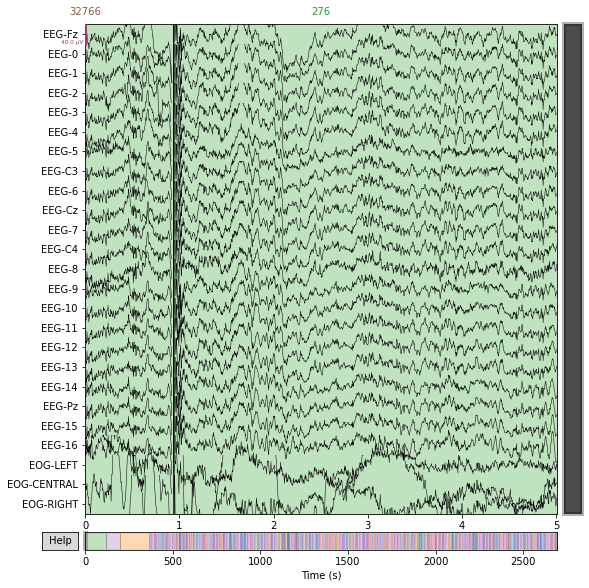

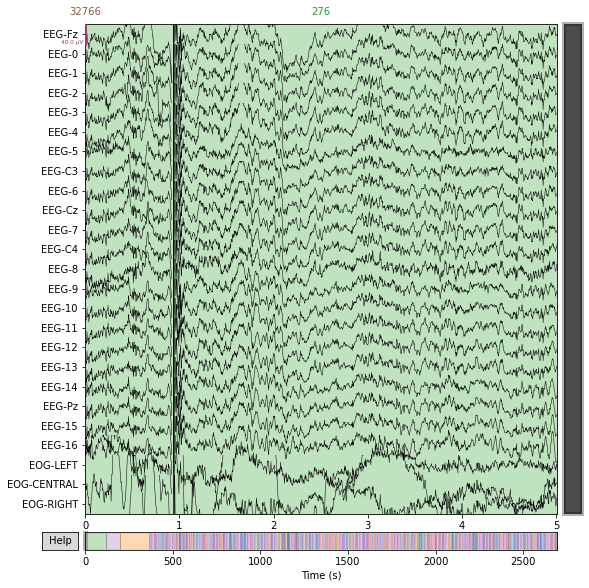

In [71]:
raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=30)

In [72]:
raw.rename_channels(lambda x: x.strip('EEG-'))
montage = mne.channels.make_standard_montage('standard_1005')

raw.set_montage(montage, on_missing='ignore')

# We are excluding the nodes that we find to not be helpful
# We are exclusively looking at nodes in the somato sensory cortex
excludeList = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', 
'12', '13', '14', '15', '16', 'OG-LEFT', 'OG-CENTRAL', 'OG-RIGHT', 'OG-1', 'OG-2', 'OG-3', 'Fz']

# Setting up band pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 sec)



<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~128.3 MB, data loaded>

In [73]:
mne.events_from_annotations(raw)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


(array([[     0,      0,      5],
        [     0,      0,      3],
        [ 29683,      0,      5],
        ...,
        [670550,      0,      6],
        [670550,      0,      1],
        [671050,      0,      7]]),
 {'1023': 1,
  '1072': 2,
  '276': 3,
  '277': 4,
  '32766': 5,
  '768': 6,
  '769': 7,
  '770': 8,
  '771': 9,
  '772': 10})

In [74]:
print(raw.to_data_frame(None, None, None))

           time            Fz             0             1             2  \
0             0 -4.235165e-15  5.082198e-15 -8.470329e-16  0.000000e+00   
1             4  9.638018e-01  3.054357e-01 -1.447843e+00 -6.756032e-01   
2             8  2.521013e+00  1.546556e+00 -1.566182e+00 -1.400988e-01   
3            12  4.727626e+00  4.003485e+00  1.456250e-01  2.029302e+00   
4            16  6.894381e+00  7.012493e+00  2.994941e+00  5.137111e+00   
...         ...           ...           ...           ...           ...   
672523  2690092 -6.352061e+00 -4.487910e+00 -6.645104e+00 -8.714742e+00   
672524  2690096 -4.317533e+00 -2.017849e+00 -3.486110e+00 -6.261152e+00   
672525  2690100 -2.482254e+00 -3.595592e-01 -1.170029e+00 -3.820293e+00   
672526  2690104 -1.076058e+00  2.029591e-01 -1.269436e-01 -1.745830e+00   
672527  2690108  3.388132e-15  4.235165e-15  0.000000e+00  5.082198e-15   

                   3             4             5            C3             6  \
0       3.388132e-1

In [75]:
# maybe filter out the bad events

def filterEventsLeft_Foot(events):
    finalArray = []
    for event in events:
        if event[2] == 8 or event[2] == 9:
            finalArray.append(event)
    return finalArray

events, _ = events_from_annotations(raw)
events = filterEventsLeft_Foot(events)

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude=excludeList)

event_id = dict(hands=8, feet=9)
epochs = Epochs(raw, events, event_id, 0, 6, proj=True, picks=picks, baseline=None, preload=True)
print(epochs.get_data().shape)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Loading data for 144 events and 1501 original time points ...
0 bad epochs dropped
(144, 4, 1501)


In [84]:
# the start of the trial happens at time instance 0 which is the cue,
# then at time instance 1 is when motor imagery happens.
epochs_train = epochs.copy().crop(tmin=1., tmax=4.)

labels = epochs.events[:, -1] - 2

print(epochs_train.get_data().shape)

(144, 4, 751)


In [77]:
scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.4, random_state=42)
cv_split = cv.split(epochs_data_train)

In [78]:

# Assemble a classifier
lda = LinearDiscriminantAnalysis()

csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)

Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 4 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 4 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 4 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 4 dim * 1.9e+09  max singular value)
    Estimated rank 

In [79]:
# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


Classification accuracy: 0.936207 / Chance level: 0.500000


<Info | 8 non-empty values
 bads: []
 ch_names: C3, Cz, C4, Pz
 chs: 4 EEG
 custom_ref_applied: False
 dig: 8 items (3 Cardinal, 5 EEG)
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 4
 projs: []
 sfreq: 250.0 Hz
>
Computing rank from data with rank=None
    Using tolerance 3.1e-06 (2.2e-16 eps * 4 dim * 3.5e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.1e-06 (2.2e-16 eps * 4 dim * 6.9e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.


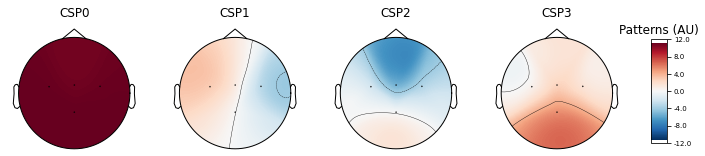

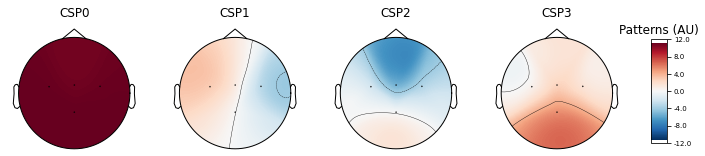

In [80]:
print(epochs.info)
# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

In [81]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

In [82]:

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 4 dim * 1.8e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 4 dim * 1.9e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 4 dim * 1.7e+09  max singular value)
    Estimated rank (mag): 4
    MAG: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 4 dim * 1.9e+09  max singular value)
    Estimated rank 

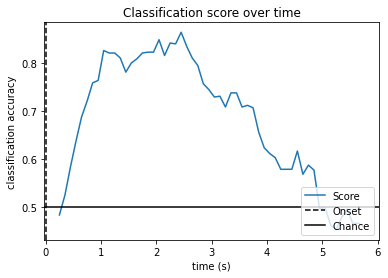

In [83]:

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()